In [74]:
from astrodendro import Dendrogram, pp_catalog
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import regions
import numpy as np
from astropy import coordinates
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import QTable, Table, Column
import matplotlib.cm as cm
from pyregion.mpl_helper import properties_func_default
from astropy.visualization import simple_norm
from astropy.stats import mad_std
#from regions import DS9Parser
import re
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import warnings
from astropy import visualization
from astropy.stats import mad_std
from astropy.io import ascii
# from astropy.table import Table
import regions
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp

from gaussfit_catalog import gaussfit_catalog
import pandas as pd
from astropy.table import vstack

import numpy as np
import astropy.constants as c
import astropy.units as u

from radio_beam import Beam

In [75]:
pwd

'/orange/adamginsburg/sgrb2/NB'

In [76]:
cd

/home/nbudaiev


In [77]:
cd /orange/adamginsburg/sgrb2/NB

/orange/adamginsburg/sgrb2/NB


In [78]:
def read_in(path):
    """
    Simplify reading in the files.
    """
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
        hdr = fh[0].header
    data=fh[0].data
    return data, wcs, hdr

In [79]:
def basefigure(data):
    """
    Set up basefigure for plotting the data. 
    """
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(projection=wcs_out)
    im = ax.imshow(data, cmap='gray_r', norm=norm1)
    
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([ax.get_position().x1-0.1,
        ax.get_position().y0,
        0.02,
        ax.get_position().height])

    cb = plt.colorbar(mappable=im, cax=cax)
    cb.ax.tick_params(labelsize=tick_fontsize)
    ax.axis([167,1617,210,1618]) # The original images nave a few extra NaN rows and columns.

    
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    radesys = wwM.wcs.radesys
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    ax.axis([0,7719,0,10579])
    return fig, ax

In [80]:
def set_up_regions(path,wX):
    """
    Modifies a CASA-created DS9 region file to a version that works with Astrodendro package.
    Adds 'source_X' text to each region, where X is a source number based on its RA.
    
    Outputs:
    includeX: original DS9 regions
    regionsX: modified version of DS9 regions that works with Astrodendro
    pixelX: same as regionsX, but with pixel coordinates.
    """
    includeX = regions.Regions.read(path)
    strX = regions.Regions.serialize(includeX, format='ds9')
    start = []
    for m in re.finditer('source=1', strX):
        start += [m.end()]
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        strM = strX[:loc] + ' text={source_' + x +'}' + strX[loc:]
    parser = regions.Regions.parse(strX, format='ds9')
    regionsX = parser.serialize(format='ds9')
    #regions.write_ds9(regionsX, 'regionsX_text.reg')
    pixelX = [region.to_pixel(wX) for region in includeX]
    return includeX, regionsX, pixelX

In [81]:
# TEST = []
# for i in range(len(cat['_idx'])):
#     if cat['_idx'][i] in cat_final['_idx']:
#         TEST+=[1]
#     else:
#         TEST+=[0]

In [127]:
Beam.from_fits_header(hdrM)

Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg

In [82]:
def set_up_catalog(d,wX,hdrX,includeX,central=False):
    """
    Creates a dendrogram catalog.
    Removes sources that are not inside includeX regions.
    Removes sources that are above level 5 in the dendrogram (removes some unwated 
    detections from extended structures).
    """
    
    my_beam = Beam.from_fits_header(hdrX)  
    scale = wX.proj_plane_pixel_scales()[0]
    
    cat = pp_catalog(d.leaves,metadata={'data_unit':u.Jy / u.beam,'beam_major':my_beam.major,'beam_minor':my_beam.minor,'beam_pa':my_beam.pa, 'wcs': wX, 'spatial_scale':scale},verbose=False)
    
    print('Total detections: '+str(len(d.leaves)))
    purgeX = []
    for i in range(len(d)):
        if d[i].level > 5: 
            purgeX += [d[i].idx]
    coordsX = coordinates.SkyCoord(cat['x_cen'], cat['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    containsX = np.zeros(len(cat),dtype=bool)
    for X in includeX:
        containsX[X.contains(coordsX, wX)] = 1
    print('Total detections inside input regions: '+str(np.sum(containsX)))
    cat_cut = cat[containsX]
    
    if central:
        print('Central region. No trimming performed')
        cat_coords = coordinates.SkyCoord(cat_cut['x_cen'], cat_cut['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_cut, cat_cut['_idx']
    else:
        cat_final= cat_cut[:0].copy()
        for i in range(len(cat_cut)):    
            if cat_cut['_idx'][i] not in purgeX:
                cat_final.add_row(cat_cut[i])
        print('Total detections after triming above level 10: '+str(len(cat_final)))
        cat_coords = coordinates.SkyCoord(cat_final['x_cen'], cat_final['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_final, cat_final['_idx']

In [83]:
def regions_gaussfit(cat_final):
    """
    Creates a DS9 region file from the catalog. The centers and sizes of each region
    are based on ['x_cen'], ['y_cen'], and ['radius'] columns in the catalog.
    """
    centerX = SkyCoord(cat_final['x_cen'], cat_final['y_cen'],unit='deg')
    # There are some problems with displaying these regions in DS9.
    # Use 1st option to display the regions in DS9.
    # Use 2nd option to have proper radii for later use.
    radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
    #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    cat_regionsX = []
    for i in range(len(centerX)):
        cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
    str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX)
    start = []
    for m in re.finditer('\)', str_cat_regionsX):
        start += [m.end()]
    str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
    str2 = '}'
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
    parser = DS9Parser(str_cat_regionsX)
    str_cat_regionsX = parser.shapes.to_regions()
    regions.write_ds9(str_cat_regionsX, "regionsN_text_degrees.reg")
    #return str_cat_regionsX

In [84]:
def makefig(data,catX_pixel,pixelX,xl=0,xu=9999,yl=0,yu=9999,plotsources=True):
    if xu == 9999:
        xu = len(data)
        yu = len(data)
    mad = mad_std(data, ignore_nan=True)
    norm = visualization.simple_norm(data, stretch='linear', min_cut=-3*mad, max_cut=8*mad,)
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8])
    fig.add_axes(ax)
    ax.axis([xl,xu,yl,yu])
    ax.imshow(data, cmap='Greys', norm=norm, origin="lower")

    cm = plt.cm.get_cmap('inferno')
    cm.set_under((0,0,0,0))
    vmin = norm.vmax*0.99
    norm2 = visualization.simple_norm(data, min_cut=vmin, stretch='log', max_percent=100)
    norm2.vmin = vmin
    im2 = ax.imshow(data, cmap='inferno',norm=norm2)
    
    
    if plotsources:
        ax.plot(catX_pixel[0],catX_pixel[1],'X',alpha=1,color='aqua')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            for region in pixelX: 
                region.plot(color='green',alpha=1,fill=False)

In [85]:
pathN='NB.sgr_b2.N.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'
pathM='NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'

In [86]:
# New files
pathN='sgr_b2.N.B3.cont.r0.5.500k0.1mjy.cal2.image.tt0.pbcor.fits'
#pathM='sgr_b2.M.B3.cont.r0.5.500k0.1mjy.cal2.image.tt0.pbcor.fits'

In [131]:
pathM='NB.sgr_b2.M.B6.cont.pb0.1.r0.5.clean100k2mjy_pcal2.image.tt0.pbcor.fits'
pathN='sgr_b2.N.B6.cont.r0.5.500k0.1mjy.cal3.image.tt0.pbcor.fits'

In [132]:
Ncal, wN, hdrN = read_in(pathN)
Mcal, wM, hdrM = read_in(pathM)

In [133]:
#B3
regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
regionsMc_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_center.reg'
regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_regions.reg'
regionsNc_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_center.reg'

#B6
regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
regionsMc_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_center.reg'
regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2NB6_YSO_regions.reg'
regionsNc_path='/orange/adamginsburg/sgrb2/NB/SgrB2NB6_YSO_center.reg'

In [134]:
includeM, regionsM, pixelM = set_up_regions(regionsM_path,wM)
includeN, regionsN, pixelN = set_up_regions(regionsN_path,wN)
includeMc, regionsMc, pixelMc = set_up_regions(regionsMc_path,wM)
includeNc, regionsNc, pixelNc = set_up_regions(regionsNc_path,wN)

In [ ]:
# def makecat(conf):
#     if conf == B3:
#         # fix files
#         pathN='NB.sgr_b2.N.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'
#         pathM='NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'
        
#         # New files
#         #pathN='sgr_b2.N.B3.cont.r0.5.500k0.1mjy.cal2.image.tt0.pbcor.fits'
#         #pathM='sgr_b2.M.B3.cont.r0.5.500k0.1mjy.cal2.image.tt0.pbcor.fits'
        
#         regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
#         regionsMc_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_center.reg'
#         regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_regions.reg'
#         regionsNc_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_center.reg'
#     else:
#         #fix M
#         pathM='NB.sgr_b2.M.B6.cont.pb0.1.r0.5.clean100k2mjy_pcal2.image.tt0.pbcor.fits'
#         pathN='sgr_b2.N.B6.cont.r0.5.500k0.1mjy.cal3.image.tt0.pbcor.fits'
#         # fix M
#         regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
#         regionsMc_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_center.reg'
#         regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2NB6_YSO_regions.reg'
#         regionsNc_path='/orange/adamginsburg/sgrb2/NB/SgrB2NB6_YSO_center.reg'
        
#     Ncal, wN, hdrN = read_in(pathN)
#     Mcal, wM, hdrM = read_in(pathM)
    
#     includeM, regionsM, pixelM = set_up_regions(regionsM_path,wM)
#     includeN, regionsN, pixelN = set_up_regions(regionsN_path,wN)
#     includeMc, regionsMc, pixelMc = set_up_regions(regionsMc_path,wM)
#     includeNc, regionsNc, pixelNc = set_up_regions(regionsNc_path,wN)
#         if conf == B3:
#             dN = Dendrogram.compute(Ncal, min_value = 0.00015, min_delta=0.00005, min_npix = 15) # Outside the center
#             dM = Dendrogram.compute(Mcal, min_value = 0.00015, min_delta=0.0001, min_npix = 15) # Outside the center
#             dMc = Dendrogram.compute(Mcal, min_value = 0.0001, min_delta=0.0003, min_npix = 10) # Central region
#             dNc = Dendrogram.compute(Ncal, min_value = 0.0001, min_delta=0.0001, min_npix = 10) # Central region
#         else:
#             dN = Dendrogram.compute(Ncal, min_value = 0.0005, min_delta=0.0002, min_npix = 50) # Outside the center B6
#             dM = Dendrogram.compute(Mcal, min_value = 0.0005, min_delta=0.0002, min_npix = 50) # Outside the center B6
#             #add center
            
#         cat_coordsM, cat_finalM, IDsM = set_up_catalog(dM,wM,hdrM,includeM,central=False)
#         cat_coordsN, cat_finalN, IDsN = set_up_catalog(dN,wN,hdrN,includeN,central=False)
#         cat_coordsMc, cat_finalMc, IDsMc = set_up_catalog(dMc,wM,hdrM,includeMc,central=True)
#         cat_coordsNc, cat_finalNc, IDsNc = set_up_catalog(dNc,wN,hdrN,includeNc,central=True)
        
#         cat_final=vstack([cat_finalM,cat_finalMc,cat_finalN,cat_finalNc])
        
        

In [135]:
#dN = Dendrogram.compute(Ncal, min_value = 0.00015, min_delta=0.00005, min_npix = 15) # Outside the center
#dM = Dendrogram.compute(Mcal, min_value = 0.00015, min_delta=0.0001, min_npix = 15) # Outside the center

#check if min val is too low
#dMc = Dendrogram.compute(Mcal, min_value = 0.0001, min_delta=0.0003, min_npix = 10) # Central region
#dNc = Dendrogram.compute(Ncal, min_value = 0.0001, min_delta=0.0001, min_npix = 10) # Central region

dN = Dendrogram.compute(Ncal, min_value = 0.001, min_delta=0.0005, min_npix = 10) # Outside the center B6 This one is good (no trimming needed)
dM = Dendrogram.compute(Mcal, min_value = 0.001, min_delta=0.0005, min_npix = 10) # Outside the center B6
dMc = Dendrogram.compute(Mcal, min_value = 0.01, min_delta=0.005, min_npix = 10)
dNc = Dendrogram.compute(Ncal, min_value = 0.007, min_delta=0.002, min_npix = 10)

In [129]:
cat_coordsN[20].to_string('hmsdms',sep=':')

'17:47:19.77107986 -28:22:40.06456964'

In [136]:
cat_coordsM, cat_finalM, IDsM = set_up_catalog(dM,wM,hdrM,includeM,central=True)

Total detections: 961
Total detections inside input regions: 78
Central region. No trimming performed


In [137]:
cat_coordsN, cat_finalN, IDsN = set_up_catalog(dN,wN,hdrN,includeN,central=True)

Total detections: 1302
Total detections inside input regions: 108
Central region. No trimming performed


In [138]:
cat_coordsMc, cat_finalMc, IDsMc = set_up_catalog(dMc,wM,hdrM,includeMc,central=True)

Total detections: 23
Total detections inside input regions: 22
Central region. No trimming performed


In [139]:
cat_coordsNc, cat_finalNc, IDsNc = set_up_catalog(dNc,wN,hdrN,includeNc,central=True)

Total detections: 42
Total detections inside input regions: 26
Central region. No trimming performed


In [ ]:
138,146,42,85

In [ ]:
186,152,252,89

In [140]:
cat_final=vstack([cat_finalM,cat_finalMc,cat_finalN,cat_finalNc])

In [91]:
len(cat_final)

421

In [144]:
#B6

In [141]:
T = 50 * u.K
d = 8.4 * u.kpc
S_nu = cat_final['flux']
k_nu = 0.002 * u.cm**2 / u.g # OH94 0.08
nu = 100 * u.GHz

In [142]:
M = S_nu * d**2 *(c.c**2)/ (2*k_nu*nu**2*c.k_B*T)

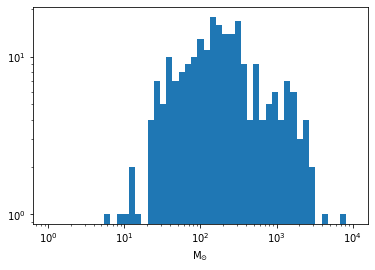

In [143]:
with visualization.quantity_support():
    plt.hist(M.to(u.solMass),bins=np.geomspace(1,10000))
    plt.loglog()

In [ ]:
#B3

[]

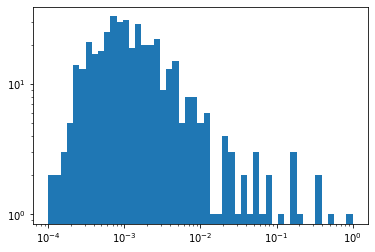

In [92]:
plt.hist(cat_final['flux'],bins=np.geomspace(10**-4,1),log=True)
plt.loglog()

In [146]:
T = 50 * u.K
d = 8.4 * u.kpc
S_nu = cat_final['flux']
k_nu = 0.008 * u.cm**2 / u.g # OH94 0.08
nu = 225 * u.GHz

In [147]:
M = S_nu * d**2 *(c.c**2)/ (2*k_nu*nu**2*c.k_B*T)

In [148]:
#from astropy import visualization

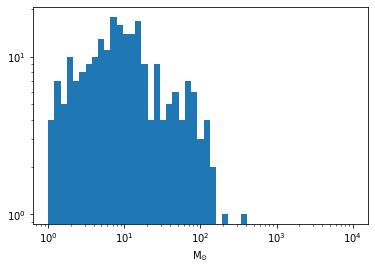

In [149]:
with visualization.quantity_support():
    plt.hist(M.to(u.solMass),bins=np.geomspace(1,10000))
    plt.loglog()

In [130]:
##################
# CATALOG
cat_final[20]
##################

_idx,area_ellipse,area_exact,flux,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen
,deg2,deg2,Jy,deg,deg,deg,deg,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3888,1.07406015737654e-09,4.29012345679081e-09,0.005856815945564296,1.7324526234145444e-05,1.4235387841303375e-05,67.11050997025114,1.5704182567389345e-05,266.83537216228785,-28.396087318370657


In [97]:
#ascii.write(cat_final, 'catalog.dat', overwrite=True)  

In [54]:
#ascii.write(cat_finalN, 'catalogN.dat', overwrite=True) 

In [55]:
#ascii.write(cat_finalNc, 'catalogNc.dat', overwrite=True) 

In [56]:
pixel_final=vstack([pixelM,pixelMc,pixelN,pixelNc])

In [57]:
fhN = fits.open(pathN)
fhM = fits.open(pathM)
mad1 = mad_std(fhN[0].data, ignore_nan=True)
norm1 = visualization.simple_norm(fhN[0].data, stretch='linear', min_cut=-10*mad1, max_cut=20*mad1,)

In [58]:
#cat_finalM.remove_columns(cat_finalM.colnames[1:])
#cat_finalN.remove_columns(cat_finalN.colnames[1:])
#cat_finalMc.remove_columns(cat_finalMc.colnames[1:])
#cat_finalNc.remove_columns(cat_finalNc.colnames[1:])
#ascii.write(cat_finalM, 'IDsM.csv', overwrite=True,format='csv')
#ascii.write(cat_finalN, 'IDsN.csv', overwrite=True,format='csv')
#ascii.write(cat_finalNc, 'IDsNc.csv', overwrite=True,format='csv')

In [59]:
catM_pixel = wM.world_to_pixel(cat_coordsM)
catN_pixel = wN.world_to_pixel(cat_coordsN)
catMc_pixel = wM.world_to_pixel(cat_coordsMc)
catNc_pixel = wN.world_to_pixel(cat_coordsNc)

In [60]:
#cat_pixel = [vstack([catM_pixel[0],catMc_pixel[0],catN_pixel[0],catNc_pixel[0]]),vstack([catM_pixel[1],catMc_pixel[1],catN_pixel[1],catNc_pixel[1]])]

In [61]:
#regN = regions.Regions.read('regionsN_text.reg') 

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wcs_out, shape_out = find_optimal_celestial_wcs([fhN,fhM])
    arrayN, footprintN = reproject_interp(fhN[0], wcs_out,shape_out)
    arrayM, footprintM = reproject_interp(fhM[0], wcs_out,shape_out)

In [45]:
top = arrayN.shape[0]
bot = arrayN.shape[1]

In [90]:
def basefigure_full(dataM,dataN,plotsources=True):
    """
    Set up basefigure for plotting the data. 
    """
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(projection=wcs_out)
    
    top = arrayN.shape[0]
    bot = arrayN.shape[1]
    #mad = mad_std(dataM, ignore_nan=True)
    #norm = visualization.simple_norm(dataM, stretch='linear', min_cut=-3*mad, max_cut=8*mad,)
    mad1= mad_std(fhN[0].data, ignore_nan=True)
    norm1 = visualization.simple_norm(fhN[0].data, stretch='linear', min_cut=-10*mad1, max_cut=20*mad1,)
    vmin = norm1.vmax*0.99
    norm2 = visualization.simple_norm(dataM, min_cut=vmin, stretch='log', max_percent=100)
    norm2.vmin = vmin
    
    im2 = ax.imshow(dataN, cmap='inferno',norm=norm2)

    im = ax.imshow(arrayM, cmap='gray_r', norm=norm1)

    im = ax.imshow(arrayN[3700:top,:], extent=[0,bot,3700,top], cmap='gray_r', norm=norm1)
    #cax = fig.add_axes([ax.get_position().x1-0.1,
    #    ax.get_position().y0,
    #    0.02,
    #    ax.get_position().height])

    # esclude for now
    #cb = plt.colorbar(mappable=im, cax=cax)
    #cb.ax.tick_params(labelsize=tick_fontsize)

    cm = plt.cm.get_cmap('inferno')
    cm.set_under((0,0,0,0))

    im2 = ax.imshow(dataM, cmap='inferno',norm=norm2)
    
    
    edgecolor = 'blue' 
    
    if plotsources:
        ax.plot(cat_coordsM.ra,cat_coordsM.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        ax.plot(cat_coordsMc.ra,cat_coordsMc.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        ax.plot(cat_coordsN.ra,cat_coordsN.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        ax.plot(cat_coordsNc.ra,cat_coordsNc.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        #with warnings.catch_warnings():
            #warnings.simplefilter('ignore')
            #for region in pixel_final: 
            #    region.plot(color='green',alpha=1,fill=False)
    
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    radesys = wM.wcs.radesys
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    #ax.axis([0,5652,0,7797])
    #ax.axis([2500,3500,4500,5500])
    #ax.axis([2500,3500,2000,3000])
    
    
    
    #ax.axis([2500,3500,2500,3500])
    #ax.axis([2500,3500,5500,6500])
    
    #ax.axis([2500,4500,6500,8500])
    ax.axis([1000,4000,4000,7000])
    #ax.axis([2500,4500,1500,3500])
    
    #plt.show()
    return fig, ax

/scratch/local/11131456/ipykernel_13672/4231093271.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


(<Figure size 864x864 with 1 Axes>,
 <WCSAxesSubplot:xlabel='RA (ICRS)', ylabel='Dec (ICRS)'>)

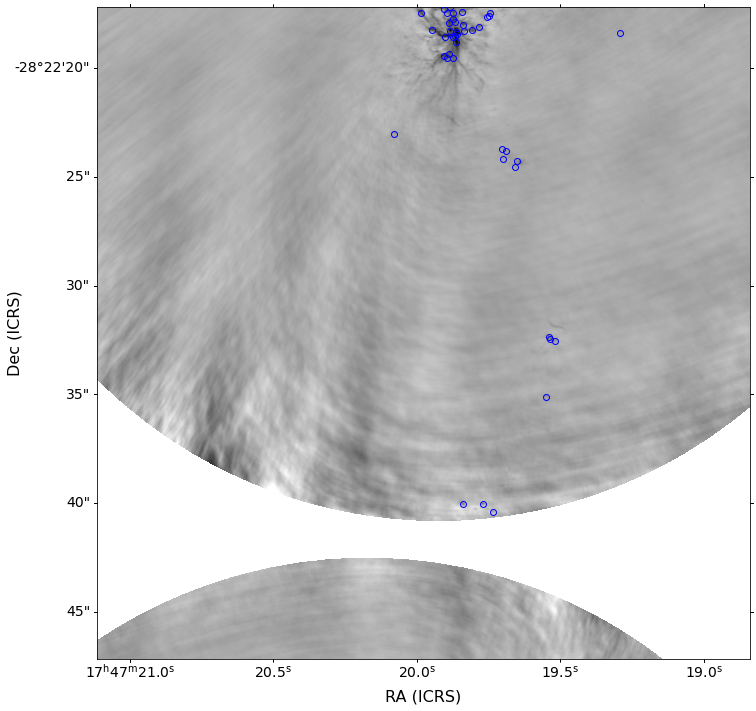

In [91]:
basefigure_full(Mcal,Ncal)

/scratch/local/11131456/ipykernel_13672/3381581480.py:35: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


(<Figure size 864x864 with 1 Axes>,
 <WCSAxesSubplot:xlabel='RA (ICRS)', ylabel='Dec (ICRS)'>)

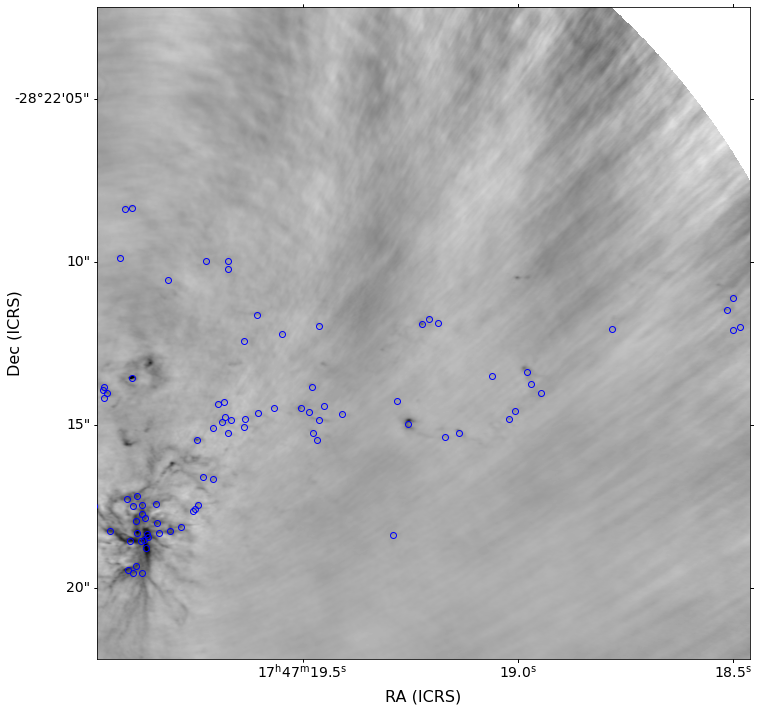

In [71]:
basefigure_full(Mcal,Ncal)

In [ ]:
makefig(Mcal,catM_pixel,pixelM)

/scratch/local/11131456/ipykernel_64129/151120807.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


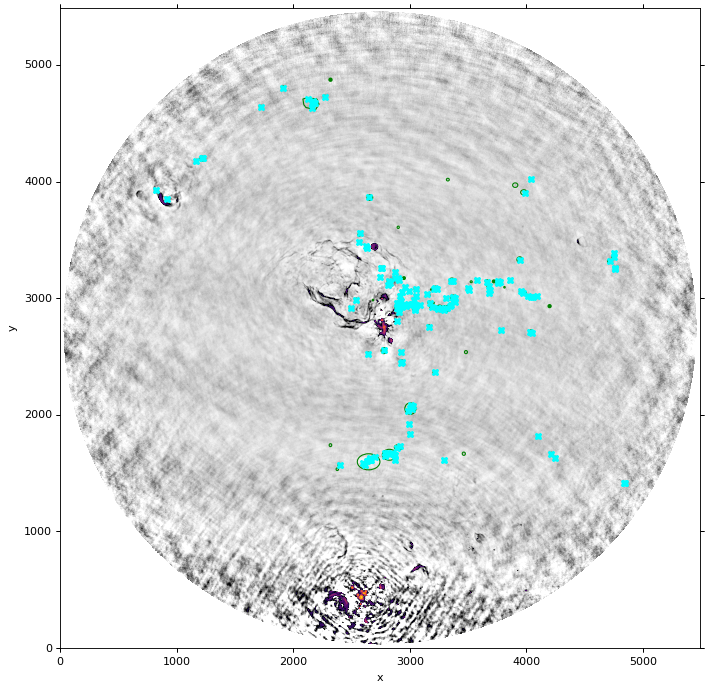

In [60]:
makefig(Ncal,catN_pixel,pixelN)

/scratch/local/11131456/ipykernel_64129/151120807.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


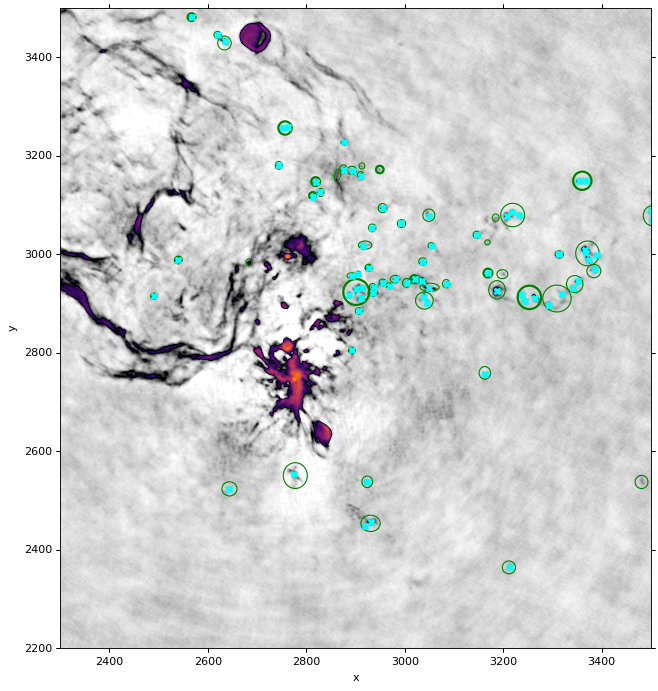

In [57]:
makefig(Ncal,catN_pixel,pixelN,2300,3500,2200,3500,plotsources=True)

In [62]:
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)

In [64]:
import astropy.units as u

In [66]:
100*u.GHz

<Quantity 100. GHz>

In [145]:
kappa(225*u.GHz)

<Quantity 0.00822712 cm2 / g>